# **I. Introduction**

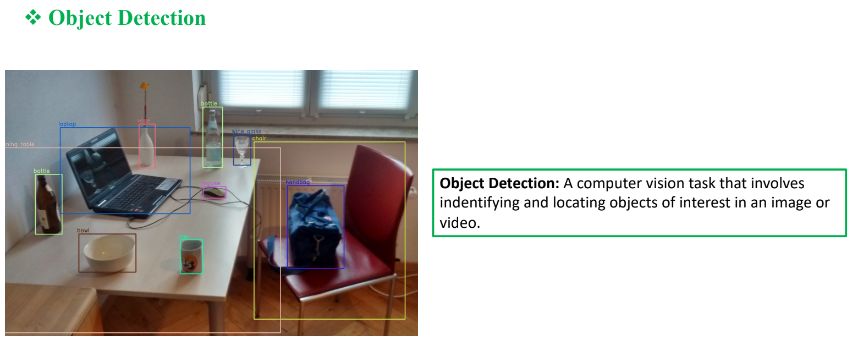

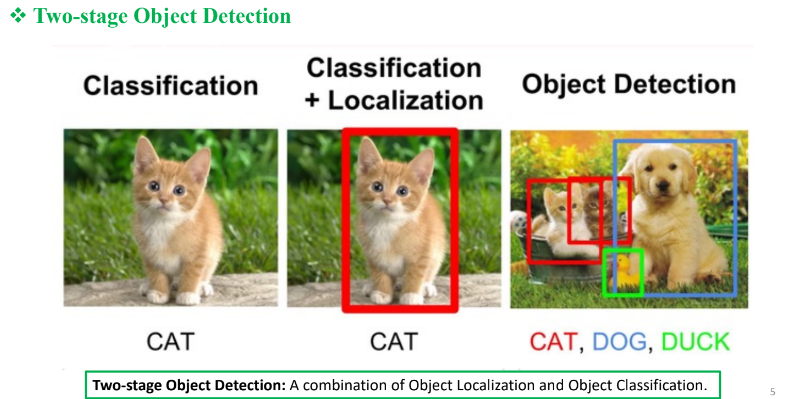

## 1. Object Localization

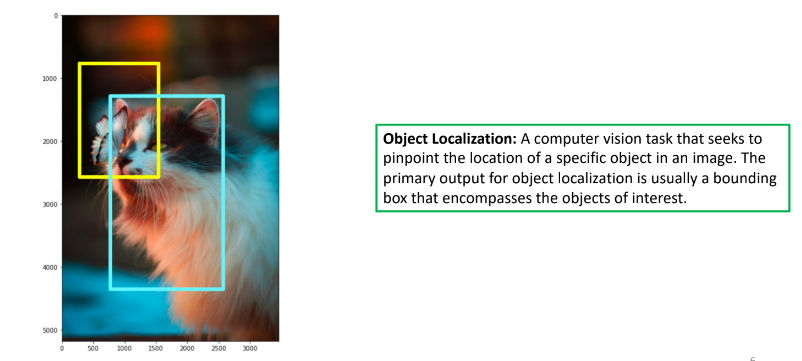

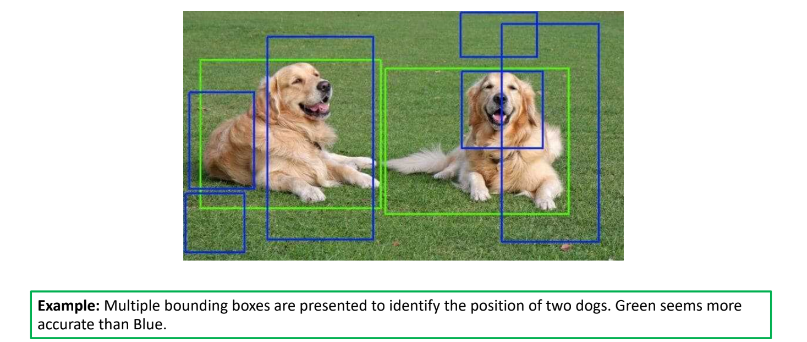

## 2. Bounding box

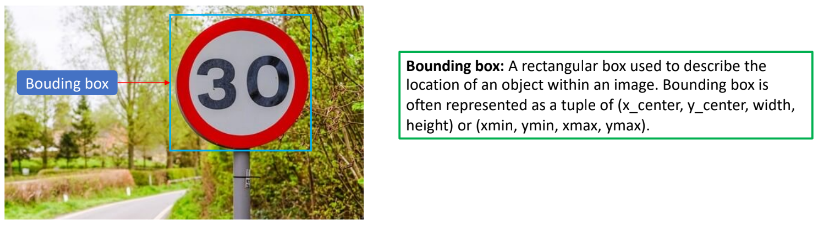

### YOLO format

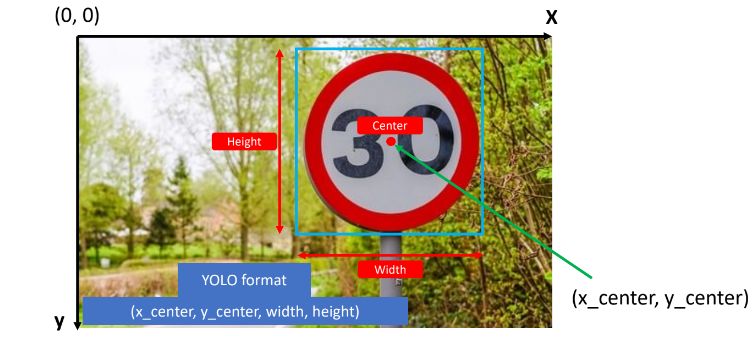

### Pascal VOC format

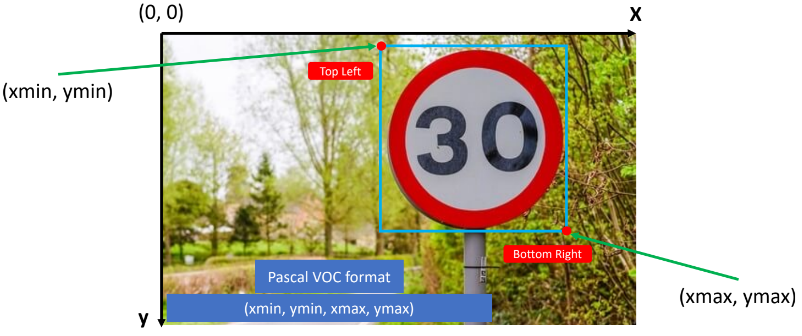

### Convert bounding box format

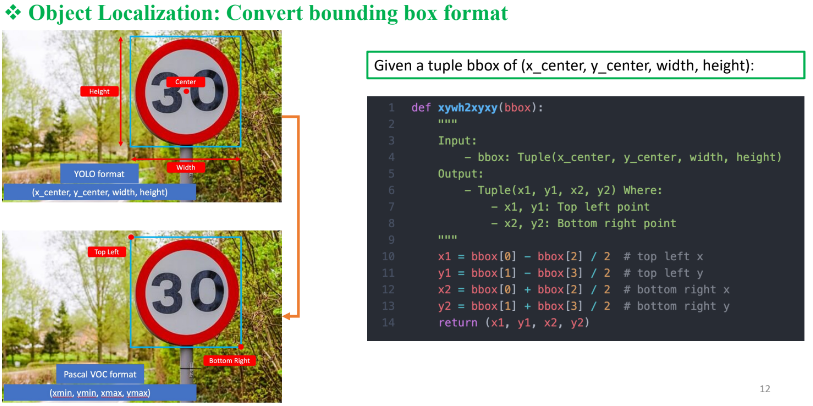

## 3. Confidence Score

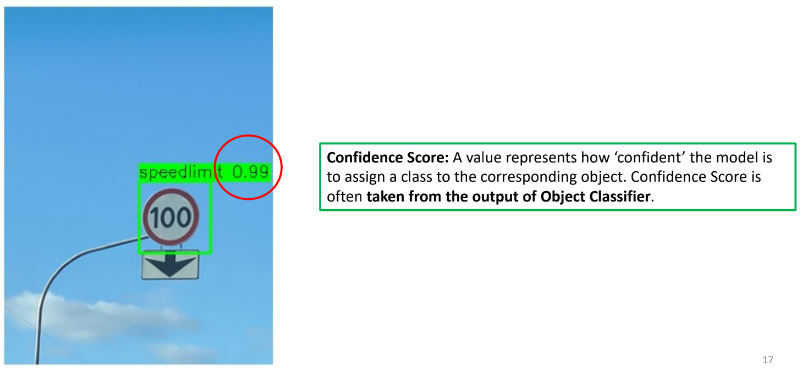

## 4. Pipeline

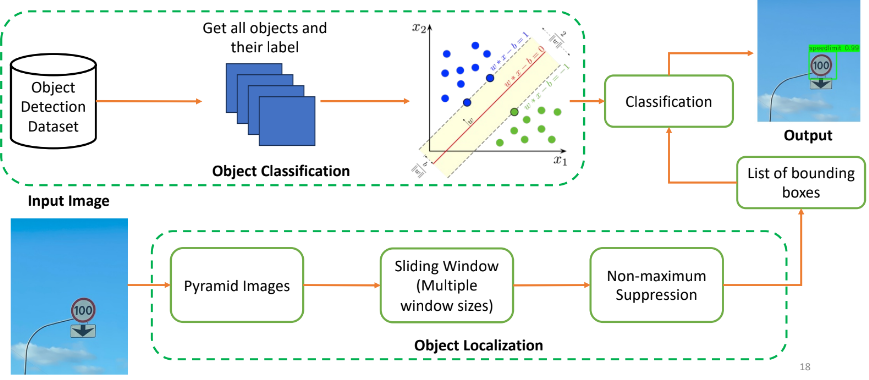

# **II. Dataset**

In [ ]:
# https://drive.google.com/file/d/1YJiHQeLotsaXAXCtLLKBHPaawqKiSC5b/view?usp=drive_link
!gdown --id 1YJiHQeLotsaXAXCtLLKBHPaawqKiSC5b

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1YJiHQeLotsaXAXCtLLKBHPaawqKiSC5b
To: /content/traffic_sign_detection.zip
100% 229M/229M [00:02<00:00, 78.9MB/s]


In [ ]:
!unzip -q traffic_sign_detection.zip

In [ ]:
# Import the necessary libraries
import time
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

from skimage.transform import resize
from skimage import feature
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# **III. Build Traffic Sign Classification Model (SVM)**

## 1. Read and extract dataset

In [ ]:
annotations_dir = 'annotations'
img_dir = 'images'

img_lst = []
label_lst = []

Next, we browse each .xml file in the annotations folder. To browse each file name in a folder, we use the os.listdir() function. To create a path to the complete .xml file, we use the os.path.join() function to join the annotations folder and the file name together:

In [ ]:
for xml_file in os.listdir(annotations_dir):
  xml_filepath = os.path.join(annotations_dir, xml_file)

With the .xml file path obtained, we proceed to read the file and some necessary information. First, we look at the format of the .xml file:

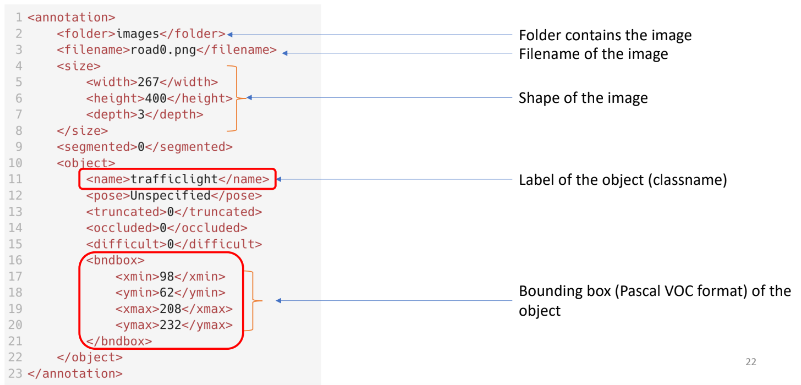

In an .xml file, information about the image, and most importantly, the coordinate information,
the class names of the objects (here, traffic signs) in that image will be provided. Since we need data
to train the image classification model, we will extract these objects into a sample
for our dataset. Thus, we will be interested in the information of the $<name>$ field
and the $<bndbox>$ field. In an $<object>$ field, $<name>$ corresponds to its class and
$<bndbox>$ indicates its coordinates in the image. To read the contents of a .xml file in python,
we can use the xml module as follows:

In [ ]:
tree = ET.parse(xml_filepath)
root = tree.getroot()
root

<function Element.keys()>

This module allows us to interact with attribute fields in a .xml file, after having
the root field, we can search/extract information of the attribute fields
in the root. For example, we can get the information of the <folder> field to read the image file as
follows:

In [ ]:
folder = root.find('folder').text # images
img_filename = root.find('filename').text # road165.png
img_filepath = os.path.join(img_dir, img_filename) # images/road165.png
img = cv2.imread(img_filepath)

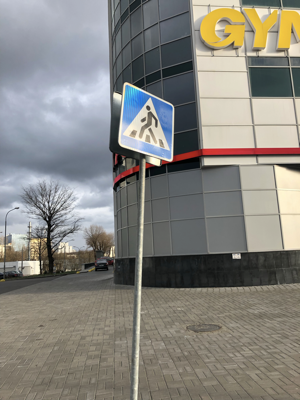

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(img)

Using the same method, we will get information about $<name>$ and $<bndbox>$ of $<object>$.
Since an image may contain many objects, we will use a loop to iterate over each object if any:

In [ ]:
for obj in root.findall('object'):
    classname = obj.find('name').text
    if classname == 'trafficlight':
        continue
    print(classname)

crosswalk


Here, we have taken the <name> information. Since our problem is only related to detecting
traffic signs, we will remove the "trafficlight" class from the dataset. Finally,
we extract the <bndbox> coordinate information and crop the object image as follows:

In [ ]:
xmin = int(obj.find('bndbox/xmin').text)
ymin = int(obj.find('bndbox/ymin').text)
xmax = int(obj.find('bndbox/xmax').text)
ymax = int(obj.find('bndbox/ymax').text)

object_img = img[ymin:ymax, xmin:xmax]
img_lst.append(object_img)
label_lst.append(classname)

With coordinates xmin, ymin, xmax, ymax; we can easily get the object image using slicing technique on the original image. Finally, we put the cropped image into the list img_lst and the class name into label_lst.

In [ ]:
annotations_dir = 'annotations'
img_dir = 'images'

img_lst = []
label_lst = []
for xml_file in os.listdir(annotations_dir):
    xml_filepath = os.path.join(annotations_dir, xml_file)
    tree = ET.parse(xml_filepath)
    root = tree.getroot()

    folder = root.find('folder').text
    img_filename = root.find('filename').text
    img_filepath = os.path.join(img_dir, img_filename)
    img = cv2.imread(img_filepath)

    for obj in root.findall('object'):
        classname = obj.find('name').text
        if classname == 'trafficlight':
            continue

        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)

        object_img = img[ymin:ymax, xmin:xmax]
        img_lst.append(object_img)
        label_lst.append(classname)

In [ ]:
print('Number of objects: ', len(img_lst))
print('Class names: ', list(set(label_lst)))

Number of objects:  1074
Class names:  ['speedlimit', 'stop', 'crosswalk']


## 2. Preprocess images

**Building an image preprocessing function**: To achieve better accuracy for the SVM model, we will
build a preprocessing function before the input image to create a better representation (feature) for the image. Specifically, we will use the **HOG (Histogram of Oriented Gradients)** feature in this article.

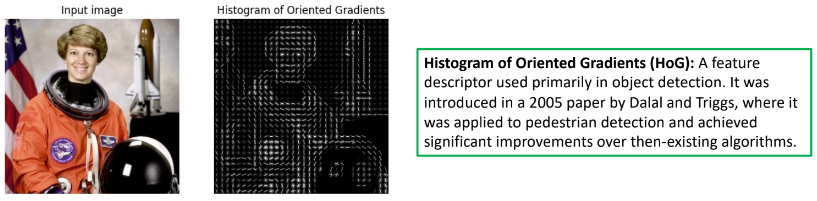

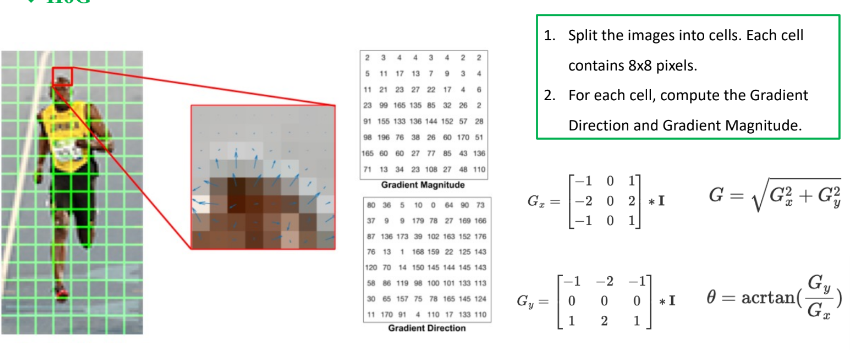

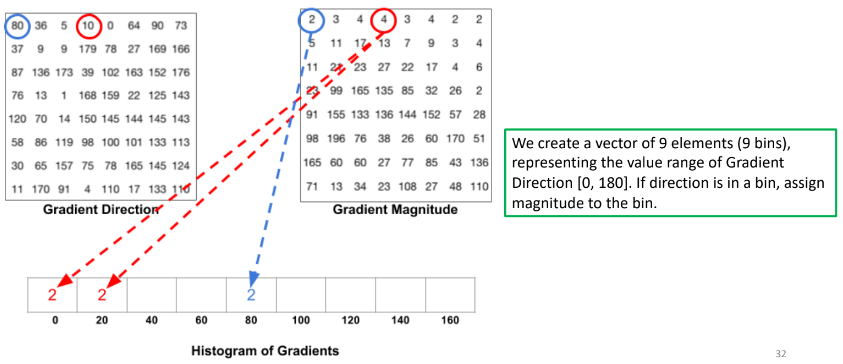

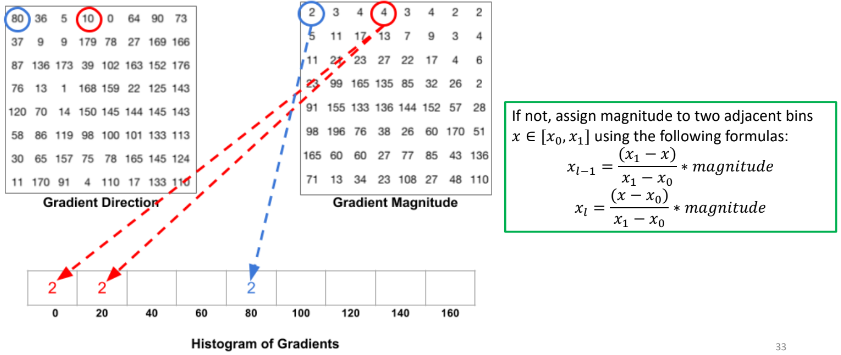

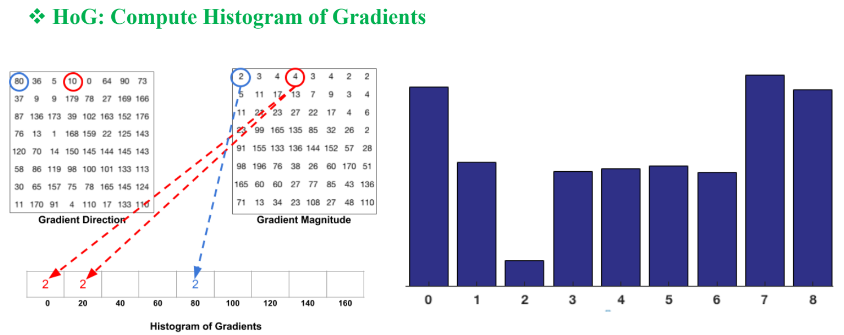

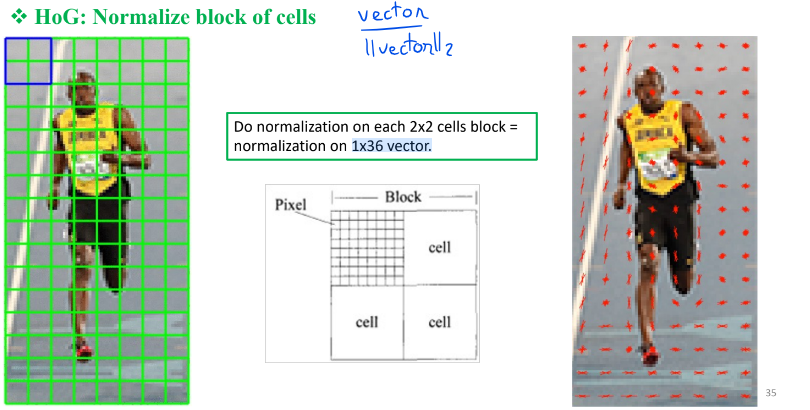

To create HOG features, you can use the feature.hog() function in the skimage library
(you can read more about this function here). So, we implement the image preprocessing function
as follows:

In [ ]:
def preprocess_img(img):
    if len(img.shape) > 2:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img.astype(np.float32)

    resized_img = resize(
        img,
        output_shape=(32, 32),
        anti_aliasing=True
    )

    hog_feature = feature.hog(
        resized_img,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        transform_sqrt=True,
        block_norm="L2",
        feature_vector=True
    )

    return hog_feature

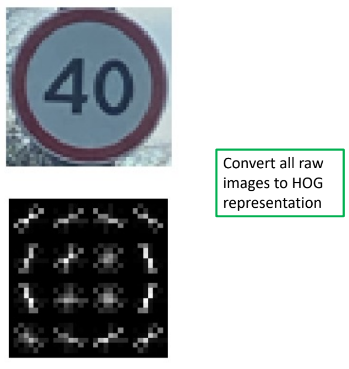

Besides HOG, you will see that we also apply the conversion of the image to grayscale
image as well as resizing the image to (32, 32) before calculating HOG. Since the objects
have different sizes, resizing is necessary so that the HOG feature vector of all images has the same shape.

In [ ]:
# Tiền xử lý ảnh
img_features_lst = []
for img in img_lst:
    hog_feature = preprocess_img(img)
    img_features_lst.append(hog_feature)

img_features = np.array(img_features_lst)

In [ ]:
print('Shape of the first image before preprocessing:', img_lst[0].shape)
print('Shape of the first image after preprocessing:', img_features[0].shape)

Shape of the first image before preprocessing: (21, 21, 3)
Shape of the first image after preprocessing: (324,)


## 3. Encode label

Currently the labels are in string form, we need to convert them to numeric form to suit the model training requirements. Here, we use LabelEncoder() to convert the class names to numbers 0, 1, 2... respectively:

In [ ]:
label_lst[:5]

['speedlimit', 'stop', 'speedlimit', 'speedlimit', 'crosswalk']

In [ ]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(label_lst)
encoded_labels

array([1, 2, 1, ..., 1, 1, 0])

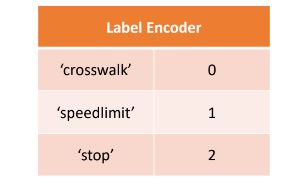

## 4. Split train val set

With the input HOG feature vector list (X) and the corresponding label list (y), we proceed to divide the current dataset into two train and val sets with a split ratio of 7:3 as follows:

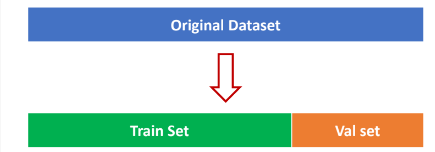

In [ ]:
random_state = 0
test_size = 0.3
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    img_features, encoded_labels,
    test_size=test_size,
    random_state=random_state,
    shuffle=is_shuffle
)

## 5. Normalization

To make the calculation and model training process go smoothly, we standardize the values ​​in the HOG feature vectors using StandardScaler():

$$z = \frac{x_{i} - μ}{σ}$$

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

## 6. Training

After completing the necessary steps, we proceed to train the SVM model on the train dataset:

In [ ]:
clf = SVC(
    kernel='rbf',
    random_state=random_state,
    probability=True, # enable Prob
    C=0.5
)
clf.fit(X_train, y_train)

SVC(C=0.5, probability=True, random_state=0)

## 7. Evaluation

So, we have completed building a traffic sign classification model. Now, we continue to build a function to determine the location of the sign in the image to complete the sign recognition program.

In [ ]:
y_pred = clf.predict(X_val)
score = accuracy_score(y_pred, y_val)

print('Evaluation results on val set')
print('Accuracy: ', score)

Evaluation results on val set
Accuracy:  0.9752321981424149


# **IV. Traffic Sign Localization (Sliding Window)**

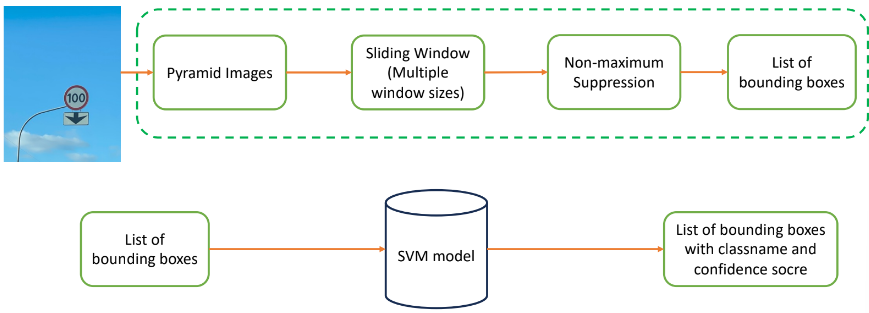

For the Object Detection problem, the most difficult task is to determine the exact coordinate position of the object
to be found. In this project, we will apply the most basic object
search technique, the Sliding Window technique. The main idea of ​​this algorithm is as follows:
- **Step 1**: Define a window frame with size (w, h). The window size must be
chosen to match the object size.
- **Step 2**: Let this window slide over each input image pixel, from left to right, top
to bottom.
- **Step 3**: With each slide, we put the recorded frame at the window frame into the sign classification model
to determine whether this window frame contains a traffic sign or not.

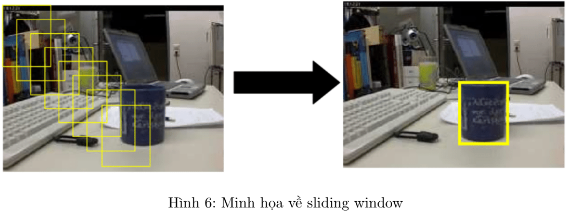

## 1. Create sliding window function

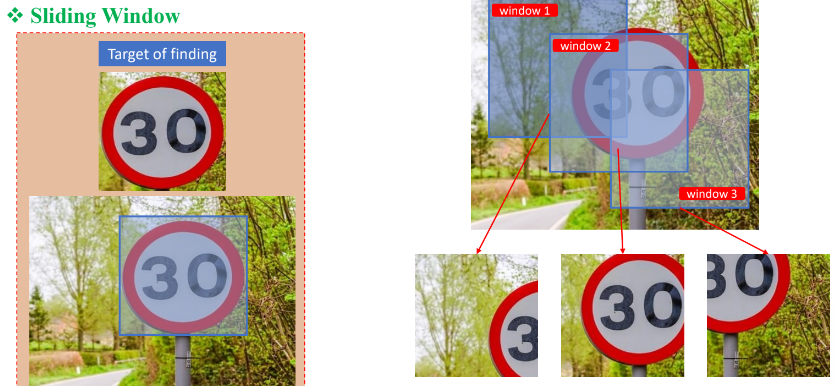

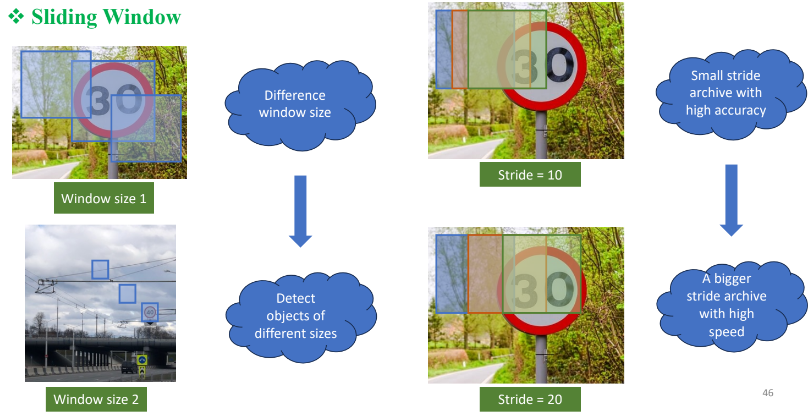

In [ ]:
def sliding_window(img, window_sizes, stride, scale_factor):
    img_height, img_width = img.shape[:2] # Get the height and width information of the input image.
    windows = [] # Initialize an empty list to store the windows (or patches).

    for window_size in window_sizes: # Iterate through each window size and get the window's width and height.
        window_width, window_height = window_size # (window_width, window_height) of the current window.

        for ymin in range(0, img_height - window_height + 1, stride): # Slide the window across the image, top to bottom, left to right.
            for xmin in range(0, img_width - window_width + 1, stride):

                xmax = xmin + window_width # Calculate xmax and ymax coordinates of the window on the image to form a list
                ymax = ymin + window_height # [xmin, ymin, xmax, ymax]. This list represents the window by its coordinate information.
                windows.append([xmin, ymin, xmax, ymax])

    return windows

However, the sliding window technique has many limitations. One of them is the search for small objects.

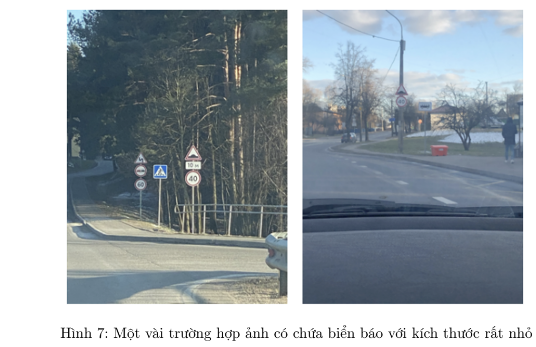

## 2. Create pyramid image function

To somewhat overcome the above situation, we can apply the Pyramid Image technique. Basically, this technique will create a series of images with gradually decreasing sizes. Then, small objects
in the original image will be larger than in the small image. From there, we apply a sliding window on the series of images
with the hope of finding small objects in the original image.

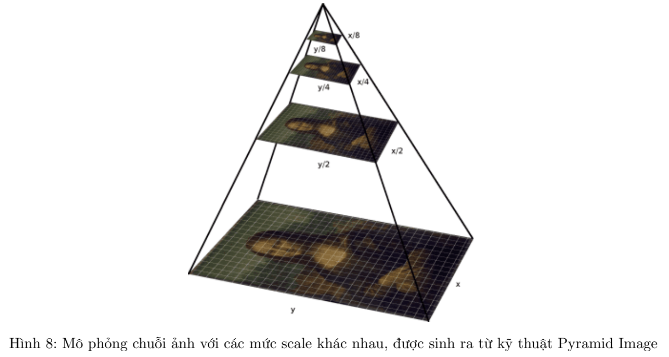

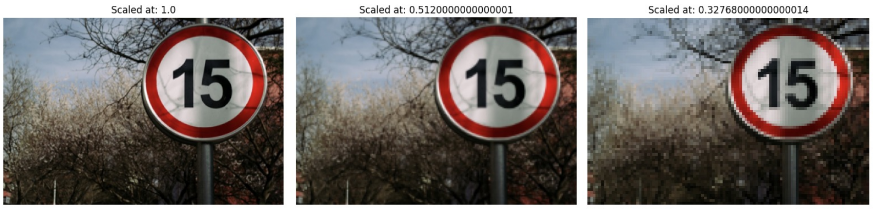

Note that applying this technique will slow down the overall prediction time of the program
as the sliding window function has to be run multiple times. To implement the pyramid function, we do the following:

In [ ]:
def pyramid(img, scale=0.8, min_size=(30, 30)):
    acc_scale = 1.0  # Variable used to store the accumulated scale factor.
    pyramid_imgs = [(img, acc_scale)] # List containing a tuple of the image at scale 1.0 (the original image) and its scale factor.

    i = 0
    while True: # Loop through each scaling level.
        acc_scale = acc_scale * scale
        # Calculate the size of the image at the new scale level.
        h = int(img.shape[0] * acc_scale)
        w = int(img.shape[1] * acc_scale)
        if h < min_size[1] or w < min_size[0]: # Check if the size falls below the minimum required size.
            break
        # Resize the image to the calculated dimensions and add it to the image pyramid list.
        img = cv2.resize(img, (w, h))
        pyramid_imgs.append((img, acc_scale * (scale ** i)))
        i += 1

    return pyramid_imgs

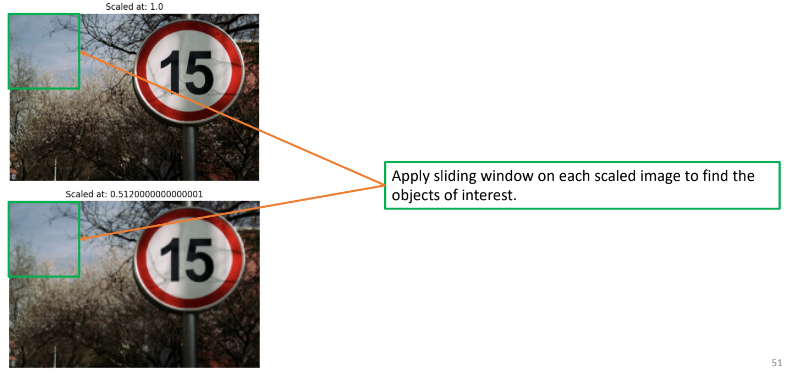

![tên_alternative_text](https://pyimagesearch.com/wp-content/uploads/2015/03/sliding-window-animated-adrian.gif)

In [ ]:
# https://pyimagesearch.com/wp-content/uploads/2015/03/sliding-window-animated-adrian.gif

## 3. Create bounding box visualization function

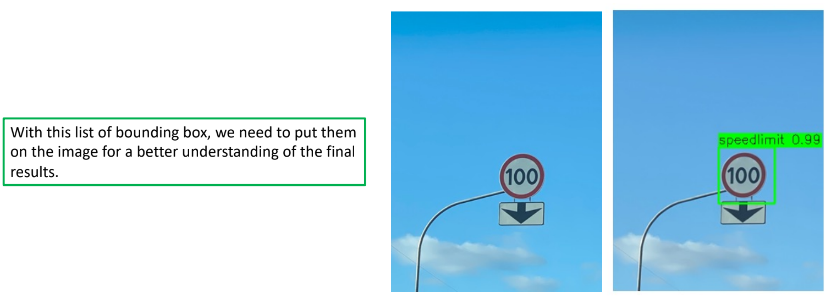

Để vẽ các bounding box tìm được lên ảnh, ta sẽ xây dựng hàm visualize các bounding box lên
như sau:

In [ ]:
def visualize_bbox(img, bboxes, label_encoder):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert BGR to RGB.

    # Iterate through the list of bounding boxes and extract their information.
    for box in bboxes:
        xmin, ymin, xmax, ymax, predict_id, conf_score = box
        # Using the coordinates xmin, ymin, xmax, ymax, draw a green rectangle (0, 255, 0) onto the image.
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
        # Convert the class ID to the class name and create a string containing the class name and the model's confidence score.
        classname = label_encoder.inverse_transform([predict_id])[0]
        label = f"{classname} {conf_score:.2f}"
        # Draw a solid green rectangle above the top-left corner of the bounding box with the information from the 'label' variable.
        (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)
        cv2.rectangle(img, (xmin, ymin - 20), (xmin + w, ymin), (0, 255, 0), -1)
        cv2.putText(img, label, (xmin, ymin - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 1)
    # Display the image with the drawn bounding boxes.
    plt.imshow(img)
    plt.axis('off')
    plt.show()

## 4. Create IoU computing function

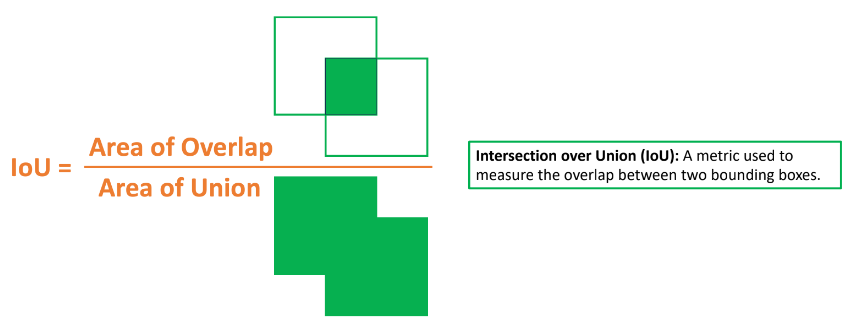

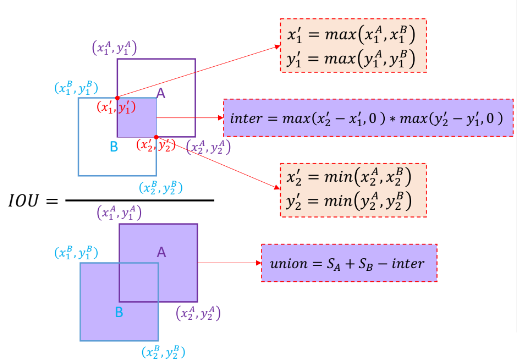

In [ ]:
def compute_iou(bbox, bboxes, bbox_area, bboxes_area):
    '''
    Step 1: Sort the list of bounding boxes in descending order of confidence score.

    Step 2: Take the bounding box with the highest confidence score, add it to the 'keep' list,
    and calculate the IoU between this bounding box and every remaining bounding box.

    Step 3: Subsequently, eliminate all bounding boxes whose IoU is greater than the given
    IoU threshold (iou_threshold).

    Step 4: With the list of bounding boxes that did not satisfy the condition in step 3,
    return to step 2 until all bounding boxes have been processed.
    '''
    # Calculate the coordinates of the intersection rectangle
    xxmin = np.maximum(bbox[0], bboxes[:, 0])
    yymin = np.maximum(bbox[1], bboxes[:, 1])
    xxmax = np.minimum(bbox[2], bboxes[:, 2])
    yymax = np.minimum(bbox[3], bboxes[:, 3])

    # Calculate the width and height of the intersection area
    w = np.maximum(0, xxmax - xxmin + 1)
    h = np.maximum(0, yymax - yymin + 1)

    # Calculate the intersection area
    intersection = w * h
    
    # Calculate IoU (Intersection / Union)
    # Union = Area(bbox) + Area(bboxes) - Intersection
    iou = intersection / (bbox_area + bboxes_area - intersection)

    return iou

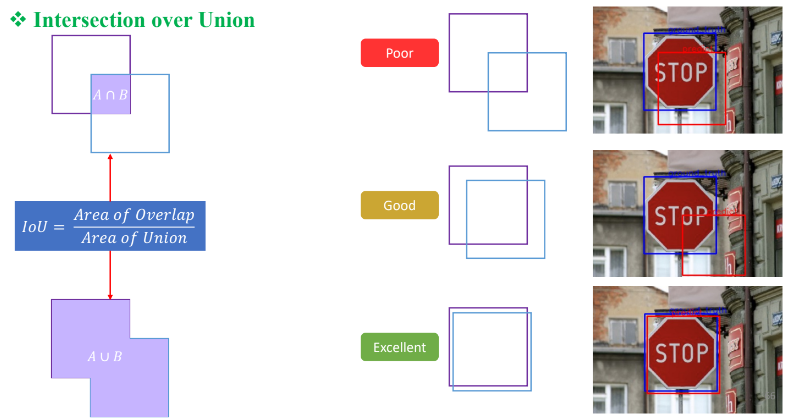

## 5. Create Non-Maximum Suppression function

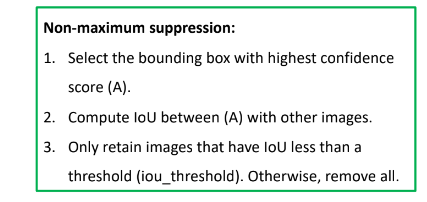

In [ ]:
def nms(bboxes, iou_threshold):
    if not bboxes: # Nếu bboxes là rỗng, ta trả về danh sách rỗng.
        return []

    # Lấy danh sách confidence score và sắp xếp chúng theo thứ tự giảm dần (kết quả trả về là chỉ mục của confidence score).
    scores = np.array([bbox[5] for bbox in bboxes])
    sorted_indices = np.argsort(scores)[::-1]

    # Lấy danh sách xmin, ymin, xmax, ymax.
    xmin = np.array([bbox[0] for bbox in bboxes])
    ymin = np.array([bbox[1] for bbox in bboxes])
    xmax = np.array([bbox[2] for bbox in bboxes])
    ymax = np.array([bbox[3] for bbox in bboxes])

    # Tính diện tích của toàn bộ bounding box.
    areas = (xmax - xmin + 1) * (ymax - ymin + 1)

    # Khai báo danh sách rỗng dùng để chứa các bounding box được giữ lại sau khi lọc.
    keep = []

    # Tạo một vòng lặp chỉ kết thúc khi danh sách điểm confidence score không còn phần tử nào.
    while sorted_indices.size > 0:
        # Lấy bounding box có điểm confidence score cao nhất và đưa vào danh sách giữ lại.
        i = sorted_indices[0]
        keep.append(i)

        # Tính IoU của bounding box có confidence score cao nhất với toàn bộ các bounding box còn lại.
        iou = compute_iou(
            [xmin[i], ymin[i], xmax[i], ymax[i]],
            np.array(
                [
                    xmin[sorted_indices[1:]],
                    ymin[sorted_indices[1:]],
                    xmax[sorted_indices[1:]],
                    ymax[sorted_indices[1:]]]
            ).T,
            areas[i],
            areas[sorted_indices[1:]]
        )
        # Giữ lại các bounding box có IoU nhỏ hơn iou_threshold để tính toán cho vòng lặp tiếp theo.
        idx_to_keep = np.where(iou <= iou_threshold)[0]
        sorted_indices = sorted_indices[idx_to_keep + 1]

    return [bboxes[i] for i in keep]

## 6. Inference code

In [ ]:
import time

img_dir = 'images'
img_filename_lst = os.listdir(img_dir)[:20]
conf_threshold = 0.95
iou_threshold = 0.1
stride = 12
window_sizes = [
    (32, 32),
    (64, 64),
    (128, 128)
]

for img_filename in img_filename_lst:
    start_time = time.time()
    img_filepath = os.path.join(img_dir, img_filename)
    print(img_filepath)
    bboxes = []
    img = cv2.imread(img_filepath)
    pyramid_imgs = pyramid(img)

    for pyramid_img_info in pyramid_imgs:
        pyramid_img, scale_factor = pyramid_img_info
        window_lst = sliding_window(
            pyramid_img,
            window_sizes=window_sizes,
            stride=stride,
            scale_factor=scale_factor
        )
        for window in window_lst:
            xmin, ymin, xmax, ymax = window
            object_img = pyramid_img[ymin:ymax, xmin:xmax]
            preprocessed_img = preprocess_img(object_img)
            normalized_img = scaler.transform([preprocessed_img])[0]
            decision = clf.predict_proba([normalized_img])[0]
            if np.all(decision < conf_threshold):
                continue
            else:
                predict_id = np.argmax(decision)
                conf_score = decision[predict_id]
                xmin = int(xmin / scale_factor)
                ymin = int(ymin / scale_factor)
                xmax = int(xmax / scale_factor)
                ymax = int(ymax / scale_factor)
                bboxes.append(
                    [xmin, ymin, xmax, ymax, predict_id, conf_score]
                )
    bboxes = nms(bboxes, iou_threshold)
    visualize_bbox(img, bboxes, label_encoder)

    print('Time process: ', time.time() - start_time)

Output hidden; open in https://colab.research.google.com to view.